<a href="https://colab.research.google.com/github/Rish-23072005/Mockmate/blob/main/Webcam_access_with_video_recording_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [32]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time


Helping Function

In [33]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

Haar Cascade Classifier
For this tutorial we will run a simple object detection algorithm called Haar Cascade on our images and video fetched from our webcam. OpenCV has a pre-trained Haar Cascade face detection model.

In [34]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

Webcam Images

In [35]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


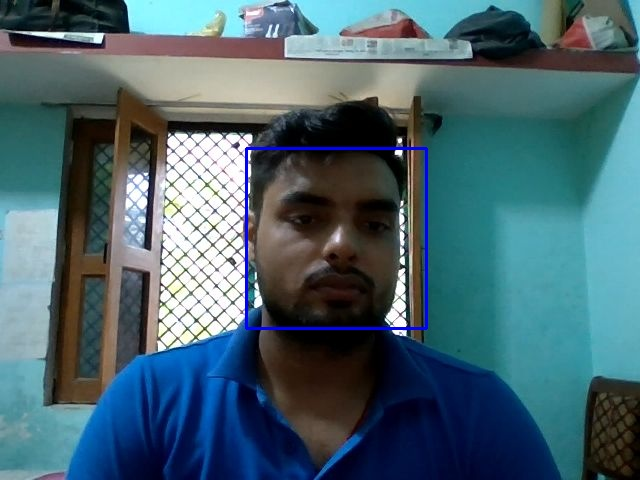

In [36]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Webcam Videos
Running code on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our progam (face detection) and create an overlay image that contains bounding box of detection(s). We then overlay the bounding box image back onto the next frame of our video stream.

In [37]:
def video_stream():
    js = Javascript('''
    var video;
    var div = null;
    var stream;
    var audioStream;
    var audioContext;
    var analyser;
    var microphone;
    var captureCanvas;
    var imgElement;
    var labelElement;
    var emotionLabel;
    var mediaRecorder;
    var recordedChunks = [];
    var audioBlob;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
        stream.getVideoTracks()[0].stop();
        audioStream.getAudioTracks()[0].stop();
        video.remove();
        div.remove();
        video = null;
        div = null;
        stream = null;
        audioStream = null;
        imgElement = null;
        captureCanvas = null;
        labelElement = null;
        emotionLabel = null;
        mediaRecorder.stop();
        audioBlob = new Blob(recordedChunks, { type: 'audio/wav' });
        var url = URL.createObjectURL(audioBlob);
        var a = document.createElement('a');
        a.style.display = 'none';
        a.href = url;
        a.download = 'output_audio.wav';
        document.body.appendChild(a);
        a.click();
        window.URL.revokeObjectURL(url);
    }

    function onAnimationFrame() {
        if (!shutdown) {
            window.requestAnimationFrame(onAnimationFrame);
        }
        if (pendingResolve) {
            var result = "";
            if (!shutdown) {
                captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
                result = captureCanvas.toDataURL('image/jpeg', 0.8);
            }
            var lp = pendingResolve;
            pendingResolve = null;
            lp(result);
        }
    }

    async function createDom() {
        if (div !== null) {
            return stream;
        }

        div = document.createElement('div');
        div.style.border = '2px solid black';
        div.style.padding = '3px';
        div.style.width = '100%';
        div.style.maxWidth = '600px';
        document.body.appendChild(div);

        const modelOut = document.createElement('div');
        modelOut.innerHTML = "<span>Status:</span>";
        labelElement = document.createElement('span');
        labelElement.innerText = 'No data';
        labelElement.style.fontWeight = 'bold';
        modelOut.appendChild(labelElement);
        div.appendChild(modelOut);

        emotionLabel = document.createElement('div');
        emotionLabel.innerHTML = "<span>Emotion:</span>";
        emotionLabel.style.fontWeight = 'bold';
        div.appendChild(emotionLabel);

        video = document.createElement('video');
        video.style.display = 'block';
        video.width = div.clientWidth - 6;
        video.setAttribute('playsinline', '');
        video.onclick = () => { shutdown = true; };
        stream = await navigator.mediaDevices.getUserMedia({ video: { facingMode: "environment" } });
        audioStream = await navigator.mediaDevices.getUserMedia({ audio: true });
        div.appendChild(video);

        imgElement = document.createElement('img');
        imgElement.style.position = 'absolute';
        imgElement.style.zIndex = 1;
        imgElement.onclick = () => { shutdown = true; };
        div.appendChild(imgElement);

        const instruction = document.createElement('div');
        instruction.innerHTML =
            '<span style="color: red; font-weight: bold;">' +
            'When finished, click here or on the video to stop this demo</span>';
        div.appendChild(instruction);
        instruction.onclick = () => { shutdown = true; };

        video.srcObject = stream;
        await video.play();

        captureCanvas = document.createElement('canvas');
        captureCanvas.width = 640;
        captureCanvas.height = 480;
        window.requestAnimationFrame(onAnimationFrame);

        audioContext = new (window.AudioContext || window.webkitAudioContext)();
        analyser = audioContext.createAnalyser();
        microphone = audioContext.createMediaStreamSource(audioStream);
        microphone.connect(analyser);

        mediaRecorder = new MediaRecorder(audioStream, { mimeType: 'audio/wav' });
        mediaRecorder.ondataavailable = function(event) {
            if (event.data.size > 0) {
                recordedChunks.push(event.data);
            }
        };
        mediaRecorder.start();

        return stream;
    }

    async function stream_frame(label, imgData) {
        if (shutdown) {
            removeDom();
            shutdown = false;
            return '';
        }

        var preCreate = Date.now();
        stream = await createDom();

        var preShow = Date.now();
        if (label != "") {
            labelElement.innerHTML = label;
        }

        if (imgData != "") {
            var videoRect = video.getClientRects()[0];
            imgElement.style.top = videoRect.top + "px";
            imgElement.style.left = videoRect.left + "px";
            imgElement.style.width = videoRect.width + "px";
            imgElement.style.height = videoRect.height + "px";
            imgElement.src = imgData;
        }

        var preCapture = Date.now();
        var result = await new Promise(function(resolve, reject) {
            pendingResolve = resolve;
        });
        shutdown = false;

        // Capture audio data for emotion recognition
        var audioData = new Float32Array(analyser.frequencyBinCount);
        analyser.getFloatFrequencyData(audioData);
        var emotion = await recognizeEmotion(audioData);
        emotionLabel.innerText = 'Emotion: ' + emotion;

        return {'create': preShow - preCreate,
                'show': preCapture - preShow,
                'capture': Date.now() - preCapture,
                'img': result};
    }
    ''')

    display(js)


In [38]:
!pip install sounddevice soundfile

In [39]:
!apt-get install -y portaudio19-dev
!pip install sounddevice

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
portaudio19-dev is already the newest version (19.6.0-1.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [40]:
!arecord -l


/bin/bash: line 1: arecord: command not found


In [41]:
!sudo apt-get install libportaudio2


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [42]:
!npm install @tensorflow/tfjs

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ @tensorflow/tfjs@4.20.0
updated 1 package and audited 102 packages in 6.736s

5 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities



   ╭────────────────────────────────────────────────────────────────╮
   │                                                                │
   │      New major version of npm available! 6.14.8 → 10.8.1       │
   │   Changelog: https://github.com/npm/cli/releases/tag/v10.8.1   │
   │               Run npm install -g npm to update!                │
   │                                                                │
   ╰────────────────────────────────────────────────────────────────╯



In [43]:
# # start streaming video from webcam
# video_stream()
# # label for video
# label_html = 'Capturing...'
# # initialze bounding box to empty
# bbox = ''
# count = 0
# while True:
#     js_reply = video_frame(label_html, bbox)
#     if not js_reply:
#         break

#     # convert JS response to OpenCV Image
#     img = js_to_image(js_reply["img"])

#     # create transparent overlay for bounding box
#     bbox_array = np.zeros([480,640,4], dtype=np.uint8)

#     # grayscale image for face detection
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#     # get face region coordinates
#     faces = face_cascade.detectMultiScale(gray)
#     # get face bounding box for overlay
#     for (x,y,w,h) in faces:
#       bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

#     bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
#     # convert overlay of bbox into bytes
#     bbox_bytes = bbox_to_bytes(bbox_array)

#     # update bbox so next frame gets new overlay
#     bbox = bbox_bytes

In [44]:
! pip install flask-ngrok

In [45]:
!pip install speechrecognition

In [46]:
%pip install pyaudio

In [47]:
%pip install pyaudio ffmpeg-python


In [55]:
!pip install pyaudio wave speechrecognition

  Preparing metadata (setup.py) ... done
  Created wheel for wave: filename=Wave-0.0.2-py3-none-any.whl size=1220 sha256=ca53ea728175412ad28ec9fb741c4980a33aa28f70bb3bd6f51ec2c011c717e1
  Stored in directory: /root/.cache/pip/wheels/f8/24/4d/1b01c0e32da3eb3fd71bbbc6093fcc557ec3b2d9e532ecd65d
Successfully built wave


In [2]:
import cv2
import pyaudio
import wave
import threading

class VideoRecorder:
    def __init__(self):
        self.open = True
        self.device_index = 0
        self.fps = 6  # Adjust the desired frame rate
        self.fourcc = "MJPG"  # Video codec (e.g., MJPG, XVID)
        self.frameSize = (640, 480)  # Video resolution (adjust as needed)

    def record_video(self):
        video_capture = cv2.VideoCapture(self.device_index)
        video_writer = cv2.VideoWriter('output_video.avi', cv2.VideoWriter_fourcc(*self.fourcc), self.fps, self.frameSize)

        while self.open:
            ret, frame = video_capture.read()
            if ret:
                video_writer.write(frame)

        video_capture.release()
        video_writer.release()

    def record_audio(self):
        audio_format = pyaudio.paInt16
        channels = 1
        rate = 44100
        chunk = 1024

        p = pyaudio.PyAudio()
        audio_stream = p.open(format=audio_format,
                              channels=channels,
                              rate=rate,
                              input=True,
                              frames_per_buffer=chunk)

        audio_frames = []

        while self.open:  # Check self.open in the loop condition
            if not self.open:
                break  # Exit loop if self.open is False

            audio_data = audio_stream.read(chunk)
            audio_frames.append(audio_data)

        audio_stream.stop_stream()
        audio_stream.close()

        wf = wave.open('output_audio.wav', 'wb')
        wf.setnchannels(channels)
        wf.setsampwidth(p.get_sample_size(audio_format))
        wf.setframerate(rate)
        wf.writeframes(b''.join(audio_frames))
        wf.close()

    def start_recording(self):
        video_thread = threading.Thread(target=self.record_video)
        audio_thread = threading.Thread(target=self.record_audio)

        video_thread.start()
        audio_thread.start()

    def stop_recording(self):
        self.open = False

if __name__ == '__main__':
    recorder = VideoRecorder()
    recorder.start_recording()

    input("Press Enter to stop recording...")
    recorder.stop_recording()
    print("Recording stopped. Video saved as 'output_video.avi' and audio as 'output_audio.wav'")


Exception in thread Thread-13 (record_audio):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-529634295594>", line 33, in record_audio
  File "/usr/local/lib/python3.10/dist-packages/pyaudio/__init__.py", line 639, in open
    stream = PyAudio.Stream(self, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pyaudio/__init__.py", line 441, in __init__
    self._stream = pa.open(**arguments)
OSError: [Errno -9996] Invalid input device (no default output device)


Press Enter to stop recording...
Recording stopped. Video saved as 'output_video.avi' and audio as 'output_audio.wav'


In [50]:
# import cv2
# import numpy as np
# import pyaudio
# import wave
# import threading
# import time
# import speech_recognition as sr

# # Global variables
# video_writer = None
# output_video_file = 'output_video.mp4'
# output_audio_file = 'output_audio.wav'
# start_time = None
# frame_interval = 1 / 30  # Interval between frames (30 frames per second)
# count = 0
# is_recording = False

# # Initialize face detector
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# # Audio recording settings
# audio_format = pyaudio.paInt16
# channels = 1
# rate = 44100
# chunk = 1024
# audio_stream = None
# audio_frames = []

# # Speech recognizer
# recognizer = sr.Recognizer()

# def start_recording():
#     global video_writer, audio_stream, audio_frames, is_recording, start_time, count

#     # Initialize video capture
#     cap = cv2.VideoCapture(0)
#     if not cap.isOpened():
#         print("Error: Could not open video capture device.")
#         return None

#     print("Video capture device opened successfully.")
#     video_writer = cv2.VideoWriter(output_video_file, cv2.VideoWriter_fourcc(*'mp4v'), 30, (640, 480))

#     # Initialize audio recording
#     p = pyaudio.PyAudio()
#     audio_stream = p.open(format=audio_format,
#                           channels=channels,
#                           rate=rate,
#                           input=True,
#                           frames_per_buffer=chunk)
#     audio_frames = []
#     is_recording = True
#     start_time = time.time()
#     count = 0

#     return cap

# def stop_recording():
#     global video_writer, audio_stream, audio_frames, is_recording
#     is_recording = False

#     if video_writer is not None:
#         video_writer.release()
#         video_writer = None

#     if audio_stream is not None:
#         audio_stream.stop_stream()
#         audio_stream.close()
#         audio_stream = None

#         # Save audio file
#         p = pyaudio.PyAudio()
#         wf = wave.open(output_audio_file, 'wb')
#         wf.setnchannels(channels)
#         wf.setsampwidth(p.get_sample_size(audio_format))
#         wf.setframerate(rate)
#         wf.writeframes(b''.join(audio_frames))
#         wf.close()

# def process_frame(cap):
#     global audio_stream, audio_frames, count

#     while is_recording:
#         ret, img = cap.read()
#         if not ret:
#             print("Failed to get video frame")
#             break

#         bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)

#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#         faces = face_cascade.detectMultiScale(gray)
#         for (x, y, w, h) in faces:
#             bbox_array = cv2.rectangle(bbox_array, (x, y), (x + w, y + h), (255, 0, 0), 2)

#         bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255

#         if video_writer is not None:
#             elapsed_time = time.time() - start_time
#             frame_timestamp = int(elapsed_time / frame_interval)

#             timer_text = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
#             cv2.putText(img, timer_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

#             video_writer.write(img)

#             while count < frame_timestamp:
#                 count += 1

#         if audio_stream is not None:
#             audio_data = audio_stream.read(chunk)
#             audio_frames.append(audio_data)

# def speech_recognition():
#     global is_recording

#     while is_recording:
#         with sr.Microphone() as source:
#             print("Listening...")
#             audio = recognizer.listen(source)
#             try:
#                 text = recognizer.recognize_google(audio)
#                 print(f"Recognized speech: {text}")
#             except sr.UnknownValueError:
#                 print("Google Speech Recognition could not understand audio")
#             except sr.RequestError as e:
#                 print(f"Could not request results from Google Speech Recognition service; {e}")

# def main():
#     cap = start_recording()
#     if cap is None:
#         return

#     video_thread = threading.Thread(target=process_frame, args=(cap,))
#     audio_thread = threading.Thread(target=speech_recognition)

#     video_thread.start()
#     audio_thread.start()

#     input("Press Enter to stop recording...")

#     stop_recording()

#     cap.release()

#     video_thread.join()
#     audio_thread.join()

#     print("Recording stopped and saved to", output_video_file)

# if __name__ == '__main__':
#     main()


Error: Could not open video capture device.
